May 2019<br>
An up to date version of this document is available at <a href='https://github.com/zlcc9/machine-learning'>github.com/zlcc9/machine-learning</a>

## 1. Introduction
This document serves as an appendix to a documented paper on the Mammographic Mass Data Set available from the UCI Machine Learning repository http://archive.ics.uci.edu/ml/datasets/mammographic+mass

This data set contains informations on 6 Variables:
1.	BI-RADS assessment (1 (definitely benign) to 5 (highly suggestive of malignancy))
2.	Age (Integer)
3.	Mass shape (1=round, 2=oval, 3=lobular, 4=irregular)
4.	Mass margin (1 = circumscribed, 2=microlobulated, 3=obscured, 4=ill-defined, 5=spiculated)
5.	Mass density (1=high, 2=iso, 3=low, 4=fat-containing) 
6.	Severity (0=benign,  1=malignant)

BI-RADS Assesment will be not be used a predictive feature, but can be used as a baseline to compare the models against.
Shape, Margin and Density are descriptors of the mass arranged from least to most suspicious of cancer.

### 1.1 Importing Data and Libraries

In [539]:
# Import basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

Missing data is labelled '?' in the raw and will be changed to NaN which is the natural way of coding missing values in Numpy and Pandas

In [540]:
# Load data set
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data'
columns = ['BI-RADS','Age', 'Shape','Margin','Density','Severity']
df = pd.read_csv(url, header=None, names=columns, na_values='?')
df.head(10)

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1
5,4.0,65.0,1.0,NaN,3.0,0
6,4.0,70.0,NaN,NaN,3.0,0
7,5.0,42.0,1.0,NaN,3.0,0
8,5.0,57.0,1.0,5.0,3.0,1
9,5.0,60.0,NaN,5.0,1.0,1


In [471]:
print(df['BI-RADS'].value_counts())

4.0     547
5.0     345
3.0      36
2.0      14
6.0      11
0.0       5
55.0      1
Name: BI-RADS, dtype: int64


One value of BI-RADS is mislabelled '55'.  This will be relabelled '5'.  BI-RADS category will then be removed from the main data set, and saved for later use.

In [472]:
# format incorrect BI-RADS and remove column for later use
df_BIRADS = df[['BI-RADS','Severity']]
df_BIRADS = df_BIRADS.replace(55,5)
df = df.drop('BI-RADS', axis=1)

### 1.2 Exploring Data Relations
Initial histograms of each feature reveal information about their distribution.

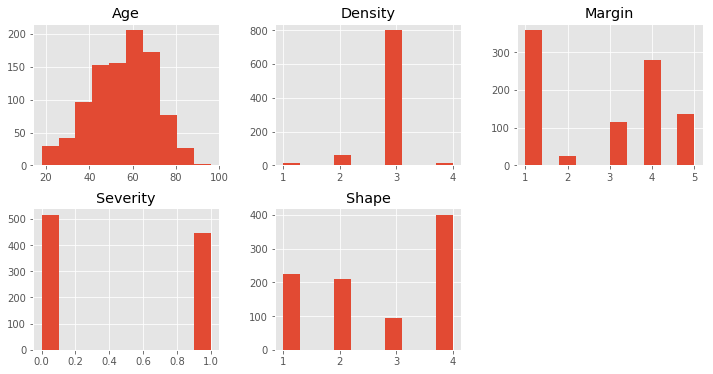

In [473]:
_ =df.hist(figsize=(12,6), layout=(2,3))

In [475]:
#Calculate percentage with malignant scan
df.Severity.sum()/len(df.Severity)*100

46.30593132154006

In [451]:
df.Age.describe()

count    956.000000
mean      55.487448
std       14.480131
min       18.000000
25%       45.000000
50%       57.000000
75%       66.000000
max       96.000000
Name: Age, dtype: float64

The data set is well-balanced with 46% positive class. Shape and margin have a much wider ditribution across categories than density.  Age has mean 55.5 (standard deviation 14.5)

Text(0.5, 1.0, 'Correlation Matrix')

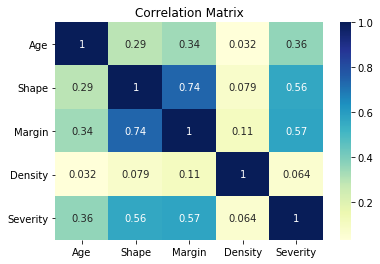

In [301]:
#Correlation
corr = df.corr()
ax = sns.heatmap(corr, annot = True, cmap="YlGnBu")
plt.setp(ax.axes.get_yticklabels(), rotation=0)
plt.title('Correlation Matrix')

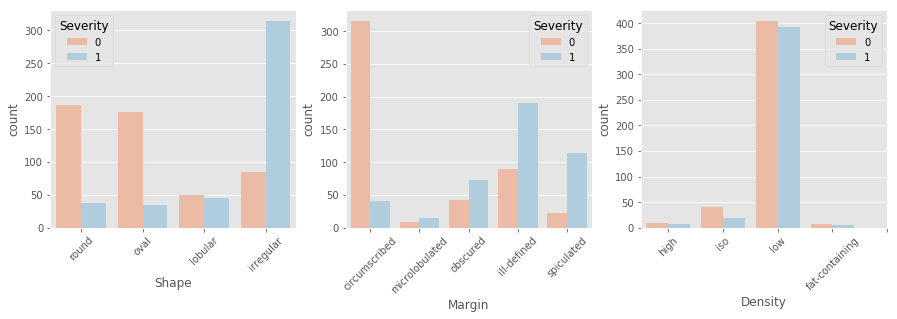

In [485]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
sns.countplot(x='Shape', hue='Severity', data=df, palette='RdBu')
plt.xticks([0,1,2,3],['round', 'oval', 'lobular','irregular'], rotation=45)

plt.subplot(1,3,2)
sns.countplot(x='Margin', hue='Severity', data=df, palette='RdBu')
plt.xticks([0,1,2,3,4],['circumscribed', 'microlobulated', 'obscured', 'ill-defined','spiculated'], rotation=45)

plt.subplot(1,3,3)
sns.countplot(x='Density', hue='Severity', data=df, palette='RdBu')
plt.xticks([0,1,2,3,4],['high','iso','low','fat-containing'], rotation=45)

plt.show()

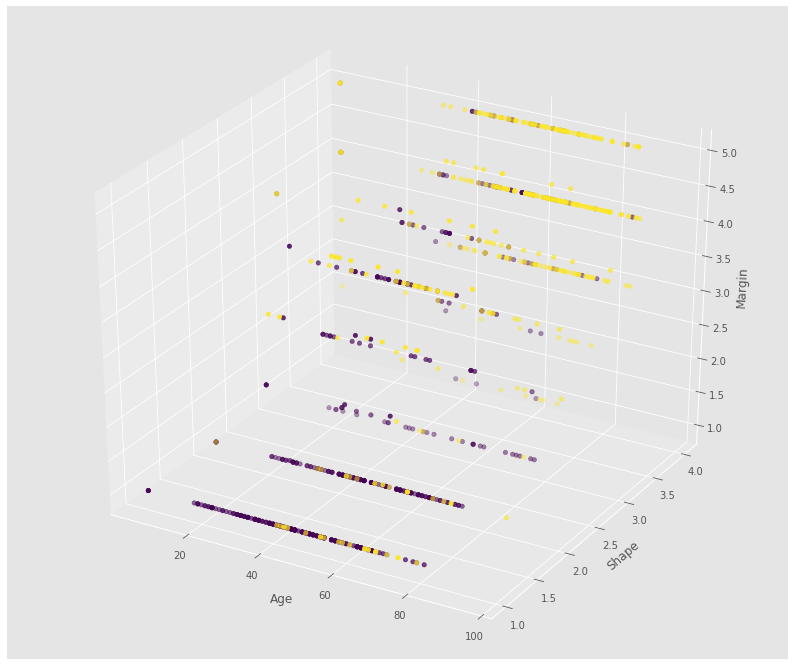

In [541]:
from mpl_toolkits.mplot3d import Axes3D

#create features
age = np.array(imputed_df.iloc[:, 0].values)
shape = np.array(imputed_df.iloc[:, 1].values)
margin = np.array(imputed_df.iloc[:, 2].values)
severity = np.array(imputed_df.iloc[:, 4].values)

fig = plt.figure(figsize=(14,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(age, shape, margin, c=severity)
ax.set_xlabel('Age')
ax.set_ylabel('Shape')
ax.set_zlabel('Margin')

plt.show()

## 2. Methods
### 2.1 Missing value Imputation
First check how many instances have missing values, and how many missing values from ech feature

In [445]:
from sklearn.impute import SimpleImputer

In [305]:
# Count missing values
df.isnull().sum()

Age          5
Shape       31
Margin      48
Density     76
Severity     0
dtype: int64

In [306]:
#Count number missing multiple values
df['missing_count'] = df['Age'].isnull().astype(int) +\
                    df['Shape'].isnull().astype(int) +\
                    df['Margin'].isnull().astype(int) +\
                    df['Density'].isnull().astype(int)
missing_counter = Counter(df['missing_count'])
print(missing_counter)
df = df.drop(['missing_count'], axis=1)

Counter({0: 831, 1: 100, 2: 30})


In [307]:
# Deal with missing data.  Option 1: drop instancs with missing data
df_complete = df.dropna(how='all') 

In [308]:
# Split by target class for mean imputation
df0 = df[df['Severity']==0]
df1 = df[df['Severity']==1]

In [309]:
# show statistics for features by class
print('total\n', df.median(),'\n')
print('benign\n',df0.median(),'\n')
print('maliganant\n',df1.median(),'\n')

total
 Age         57.0
Shape        3.0
Margin       3.0
Density      3.0
Severity     0.0
dtype: float64 

benign
 Age         49.0
Shape        2.0
Margin       1.0
Density      3.0
Severity     0.0
dtype: float64 

maliganant
 Age         63.0
Shape        4.0
Margin       4.0
Density      3.0
Severity     1.0
dtype: float64 



In [310]:
# impute median values according to taret class
imr0 = SimpleImputer(missing_values=np.nan, strategy='median')  #or try strategy='most_frequent'
imr0 = imr0.fit(df0)
imputed_data0 = imr.transform(df0.values)

imr1 = SimpleImputer(missing_values=np.nan, strategy='median')
imr1 = imr1.fit(df1)
imputed_data1 = imr.transform(df1.values)

imputed_data = np.concatenate((imputed_data0, imputed_data1), axis=0)

In [525]:
imputed_df = pd.DataFrame(data=imputed_data, columns=columns[1:])
imputed_df.head()

,Age,Shape,Margin,Density,Severity
0,28.0,1.0,1.0,3.0,0.0
1,65.0,1.0,1.0,3.0,0.0
2,70.0,2.0,1.0,3.0,0.0
3,42.0,1.0,1.0,3.0,0.0
4,64.0,1.0,1.0,3.0,0.0


### 2.2 Baseline model based on BI-RADS

The plot below illustrates that depending on the threshold that is chosen, if BI-RADS alone is used to detect malignancy then a threshold of 4 or more will have high sensitivity (recall 0.98) but a low specificity (precision 0.48), while a threshold of 5 or above will have high specificity (precision 0.88) and lower sensitivity (0.71). 

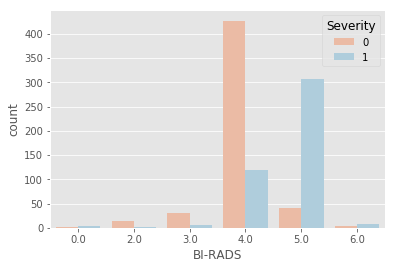

In [352]:
# Plot distribution of BI-RADS
sns.countplot(x='BI-RADS', hue='Severity', data=df_BIRADS, palette='RdBu')

In [488]:
#drop values that are out of range 1-5
df_BIRADS = df_BIRADS[df_BIRADS['BI-RADS']!=0]
df_BIRADS = df_BIRADS[df_BIRADS['BI-RADS']!=6]

# Make predictions based on threshold 4 or more
df_BIRADS['Prediction4'] = (df_BIRADS['BI-RADS']>=4).astype(int)
y_test_BIRAD = df_BIRADS['Severity']
y_pred_BIRAD4 = df_BIRADS['Prediction4']
print('\nClassification Report: Threshold BI-RADS 4\n',classification_report(y_test_BIRAD,y_pred_BIRAD4))

# Make predictions based on thrshold 5 or more
df_BIRADS['Prediction5'] = (df_BIRADS['BI-RADS']>=5).astype(int)
y_pred_BIRAD5 = df_BIRADS['Prediction5']
print('\nClassification Report: Threshold BI-RADS 5\n',classification_report(y_test_BIRAD,y_pred_BIRAD5))


Classification Report: Threshold BI-RADS 4
               precision    recall  f1-score   support

           0       0.85      0.09      0.16       511
           1       0.48      0.98      0.64       434

   micro avg       0.50      0.50      0.50       945
   macro avg       0.66      0.53      0.40       945
weighted avg       0.68      0.50      0.38       945


Classification Report: Threshold BI-RADS 5
               precision    recall  f1-score   support

           0       0.79      0.92      0.85       511
           1       0.88      0.71      0.78       434

   micro avg       0.82      0.82      0.82       945
   macro avg       0.84      0.81      0.82       945
weighted avg       0.83      0.82      0.82       945



Although in clinical practice, a recall of 0.71 would be unacceptable for a screening test, for the purposes of a comparison, a threshold of 5 has a higher accuracy, so this level of accuracy will be used as a benchmark.

In [489]:
print("Accuracy at threshold 4: {0:.4f}".format(accuracy_score(y_test_BIRAD, y_pred_BIRAD4)))
print("Accuracy at threshold 5: {0:.4f}".format(accuracy_score(y_test_BIRAD, y_pred_BIRAD5)))

Accuracy at threshold 4: 0.4974
Accuracy at threshold 5: 0.8222


## 2.2 Train-Test Split
In order to obtain an unbiased estimate of a model’s performance, it must be evaluated on an unseen test set, so the data is partitioned to create a hold-out set of data for later testing on.  The data is randomly split, but using a random state so that the model is reproducible.

In [490]:
from sklearn.model_selection import train_test_split

In [502]:
X = imputed_data[:,0:4].astype(float)
y=imputed_data[:,4].astype(int)

In [503]:
#split data into training and test portions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## 2.3  K-Nearest Neighbour Model
The first model to be used is K-nearest neighbours.  Features for this model need to be numerical.  Although the features are categorical, they are on an ordinal scale from least to most malignant, so could be used in this application

In [542]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

In [543]:
# Running a simple model where n-neighbours has been allocated 5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [544]:
# Accuracy
print('Training score:', knn.score(X_train,y_train))
print('Testing score:',knn.score(X_test,y_test))

Training score: 0.8359375
Testing score: 0.7772020725388601


This model (with n_neighbours=5) does not perform as well on the test set as on the training set, as would be expected.  The comparison between the training at test sets is shown below with varying numbers of neighbours

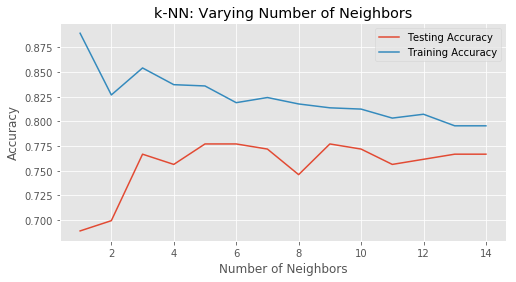

In [554]:
# Different number of k
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.figure(figsize=(8,4))
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


Cross validation is a technique where several models are trained, each time a different chunk of the data is held out, and the testing score on the remaining portion

In [518]:
# Cross validated accuracy
scores = cross_val_score(knn, X_train, y_train, cv=5)
print(scores)
print ('mean: {:.3f}'.format(scores.mean()))

[0.70322581 0.7987013  0.75163399 0.79084967 0.77124183]
mean: 0.763


In [513]:
steps = [('normalize', MinMaxScaler()),
        ('knn',KNeighborsClassifier())]

knn_pipeline = Pipeline(steps)

param_grid = {'knn__n_neighbors': np.arange(1,10),
             'knn__p': [1,2],
             'knn__weights' : ['uniform','distance',]} 

#set up grid search
knn_cv = GridSearchCV(knn_pipeline,param_grid, cv=10)

knn_cv.fit(X_train, y_train)
print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}
0.79296875


/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [547]:
# without normalizing data
steps = [('knn',KNeighborsClassifier())]

knn_pipeline = Pipeline(steps)

param_grid = {'knn__n_neighbors': np.arange(1,10),
             'knn__p': [1,2],
             'knn__weights' : ['uniform','distance',]} 

#set up grid search
knn_cv = GridSearchCV(knn_pipeline,param_grid, cv=10)

knn_cv.fit(X_train, y_train)
print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
0.7825520833333334


/Users/tom/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Decision Tree
Decision trees have many parameters that can be tuned, such as max_features, max_depth, and min_samples_leaf: This makes it an ideal use case for RandomizedSearchCV.

In [528]:
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier

# Setup the parameters and distributions to sample from: param_dist
param_ = {"max_depth": [1,2,3,4,5,6,7,8,9, None],
          "max_features": randint(1, 4),
          "min_samples_leaf": randint(1, 9),
          "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train,y_train)

#Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 4}
Best score is 0.7864583333333334


In [531]:
tree = DecisionTreeClassifier(criterion='gini',max_depth=4)
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

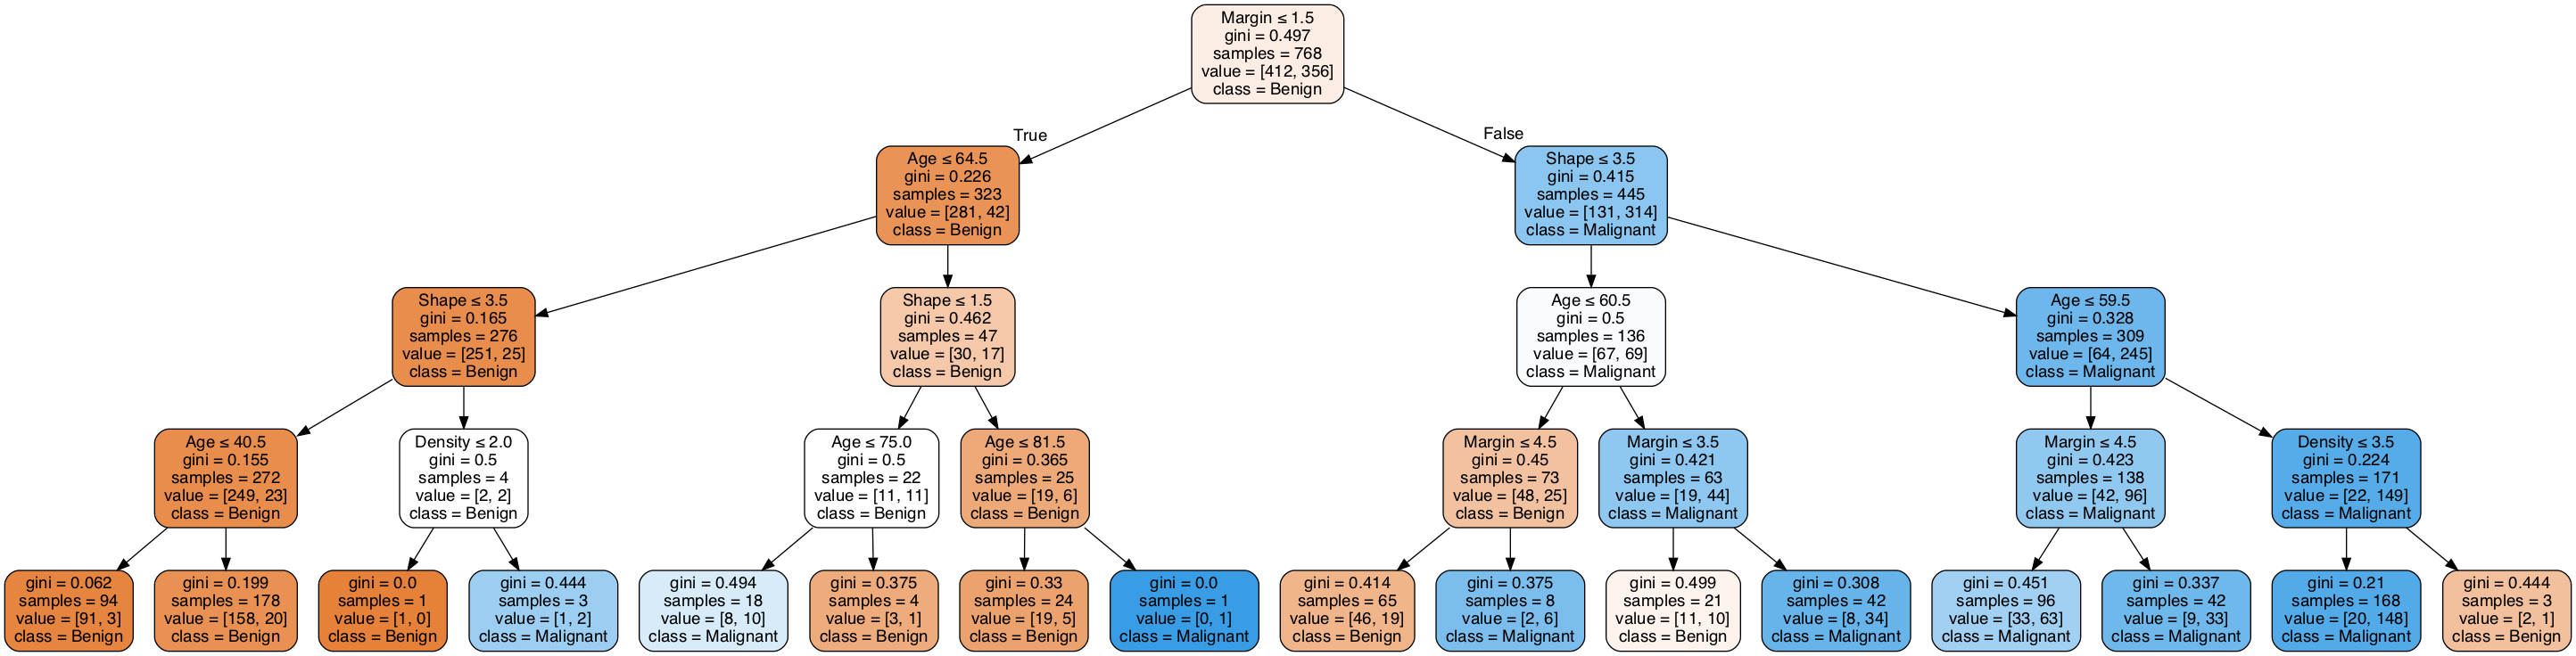

In [532]:
import graphviz 
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
dot_data=StringIO()
dot_data = export_graphviz(tree, out_file = None, feature_names=columns[1:-1], class_names=['Benign', 'Malignant'], 
                filled=True, rounded=True, special_characters=True) 

graph = pydotplus.graph_from_dot_data(dot_data)
#print(dot_data)
Image(graph.create_png())

### 3. Results

In [533]:
tree.score(X_test,y_test)

0.8031088082901554